In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [48]:
users = pd.read_csv('../data/BX-Users.csv',encoding='ISO-8859-1',sep= ';')
ratings = pd.read_csv('../data/BX-Book-Ratings.csv',encoding='ISO-8859-1',sep= ';')
books = pd.read_csv('../data/books.csv')

In [49]:
df = pd.merge(pd.merge(ratings , users), books)
df = df[['User-ID', 'ISBN', 'Book-Rating', 'title']]
df.head()

,User-ID,ISBN,Book-Rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [50]:
print("Statistics before removing 0 ratings")
print(str(df.shape [0]) +" ratings")
print(df['User-ID'].nunique() ," users")
print(df['ISBN'].nunique(), " books")

Statistics before removing 0 ratings
462694 ratings
59865  users
113333  books


In [51]:
df = df[(df['Book-Rating'] > 0)]
print("Statistics after removing 0 ratings")
print(str(df.shape [0]) +" ratings")
print(df['User-ID'].nunique() ," users")
print(df['ISBN'].nunique(), " books")

Statistics after removing 0 ratings
179200 ratings
43374  users
65306  books


<AxesSubplot:>

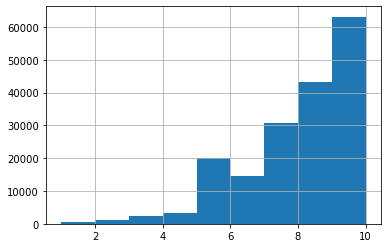

In [52]:
df['Book-Rating'].hist(bins=9)

In [53]:
df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
title          0
dtype: int64

In [54]:
overview = df.groupby('title')['Book-Rating'].agg('count').sort_values(ascending=False)
overview = pd.DataFrame(overview)
overview = overview[overview['Book-Rating'] > 10]
overview

,Book-Rating
title,
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,491
The Nanny Diaries: A Novel,393
The Red Tent (Bestselling Backlist),383
...,...
Blood Test,11
Harmful Intent,11
The Sorcerer's Companion: A Guide to the Magical World of Harry Potter,11


In [55]:
df = df[df.title.isin(overview.index.array)]
df.shape

(77746, 4)

In [56]:
df_train, df_test = train_test_split(df, test_size=0.01)

In [57]:
print(df_train.shape)
print(df_test.shape)

(76968, 4)
(778, 4)


In [58]:
matrix = df_train.pivot_table(index=['User-ID'],columns=['title'],values = 'Book-Rating').fillna(0)
matrix.head()

title,10 Lb. Penalty,"14,000 Things to Be Happy About",1984,1st to Die: A Novel,2010: Odyssey Two,2061: Odyssey Three,253,2nd Chance,4 Blondes,50 Simple Things You Can Do to Save the Earth,...,You Shall Know Our Velocity,You're Only Old Once! : A Book for Obsolete Children,Young Wives,Yukon Ho!,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zodiac: The Eco-Thriller,\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",iI Paradiso Degli Orchi,stardust
User-ID,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
corr_matrix = matrix.corr(method='pearson')
corr_matrix.head()

title,10 Lb. Penalty,"14,000 Things to Be Happy About",1984,1st to Die: A Novel,2010: Odyssey Two,2061: Odyssey Three,253,2nd Chance,4 Blondes,50 Simple Things You Can Do to Save the Earth,...,You Shall Know Our Velocity,You're Only Old Once! : A Book for Obsolete Children,Young Wives,Yukon Ho!,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zodiac: The Eco-Thriller,\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",iI Paradiso Degli Orchi,stardust
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,1.000000,-0.000518,-0.001421,0.042413,-0.000742,0.025049,-0.000483,0.012489,-0.000965,-0.000620,...,-0.000669,-0.000482,-0.000641,-0.000621,-0.001236,-0.000639,0.043984,-0.000562,-0.000570,-0.000710
"14,000 Things to Be Happy About",-0.000518,1.000000,-0.001325,0.038892,-0.000692,-0.000568,0.062967,0.017048,-0.000899,-0.000578,...,-0.000623,0.074174,0.046679,0.052349,0.022352,0.057836,0.026272,-0.000524,-0.000531,0.044743
1984,-0.001421,-0.001325,1.000000,0.013514,0.055930,-0.001560,-0.001237,-0.004272,-0.002467,-0.001587,...,0.014636,-0.001234,-0.001639,-0.001588,0.032855,0.062230,-0.002865,-0.001438,-0.001458,0.024769
1st to Die: A Novel,0.042413,0.038892,0.013514,1.000000,0.005403,-0.002323,0.018327,0.159308,-0.003674,0.009102,...,0.020793,0.042990,0.025959,0.026105,0.009528,0.027161,0.069230,-0.002141,-0.002171,0.017752
2010: Odyssey Two,-0.000742,-0.000692,0.055930,0.005403,1.000000,0.131625,-0.000646,-0.002231,-0.001289,-0.000829,...,-0.000893,-0.000644,-0.000856,-0.000829,0.032888,0.019182,-0.001496,-0.000751,-0.000761,-0.000949


In [60]:
def get_similar(title, rating):
    similar_ratings = corr_matrix[title]*(rating-5.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

In [61]:
def recommend_books(user_rated_books):
    similar_books = pd.DataFrame()
    for book,rating in user_rated_books:
        similar_books = pd.concat([similar_books,get_similar(book,rating).to_frame().T],ignore_index=True)

    result = similar_books.mean().sort_values(ascending=False)
    return result

In [62]:
first_lotr_book = [("The Fellowship of the Ring (The Lord of the Rings, Part 1)",10)]

all_lotr_books = [("The Fellowship of the Ring (The Lord of the Rings, Part 1)",10),
            ("The Two Towers (The Lord of the Rings, Part 2)", 10),
            ("The Return of the King (The Lord of the Rings, Part 3)",10)]


In [63]:
recommend_books(first_lotr_book)

title
The Fellowship of the Ring (The Lord of the Rings, Part 1)                      4.500000
The Two Towers (The Lord of the Rings, Part 2)                                  1.720491
The Return of the King (The Lord of the Rings, Part 3)                          1.656070
The Hobbit : The Enchanting Prelude to The Lord of the Rings                    0.879827
The Magic School Bus Lost in the Solar System (Magic School Bus (Paperback))    0.454380
                                                                                  ...   
The Valley of Horses                                                           -0.016094
Hearts In Atlantis                                                             -0.016503
Memoirs of a Geisha Uk                                                         -0.017981
While I Was Gone                                                               -0.022244
The No. 1 Ladies' Detective Agency (Today Show Book Club #8)                   -0.025960
Length: 2102, d

In [64]:
recommend_books(all_lotr_books)

title
The Two Towers (The Lord of the Rings, Part 2)                       2.909265
The Return of the King (The Lord of the Rings, Part 3)               2.887792
The Fellowship of the Ring (The Lord of the Rings, Part 1)           2.625520
The Hobbit : The Enchanting Prelude to The Lord of the Rings         0.962153
The Silmarillion                                                     0.428731
                                                                       ...   
Sisterhood of the Traveling Pants                                   -0.013178
What to Expect When You're Expecting (Revised Edition)              -0.013303
Back When We Were Grownups : A Novel (Ballantine Reader's Circle)   -0.013776
Hearts In Atlantis                                                  -0.014403
While I Was Gone                                                    -0.019413
Length: 2102, dtype: float64

In [65]:
#Test
# zda lze předpovědět review na základě dat v train
# user a book musí být v train setu
# jen ověřit +-5, korelace není metrika skóre

df_test.shape

(778, 4)

In [66]:
df_test1 = df_test[(df_test['User-ID'].isin(df_train['User-ID']))]
df_test2 = df_test1[(df_test1['ISBN'].isin(df_train['ISBN']))]
df_test2.shape

(606, 4)

In [67]:
def predict_rating(user_id,title):
    user_ratings = []
    user_ratings_df = df_train[df_train['User-ID'] == user_id][['title','Book-Rating']]
    for index, row in user_ratings_df.iterrows():
        user_ratings.append((row['title'],row['Book-Rating']))
    return recommend_books(user_ratings)[title]

In [68]:
df_test2['Prediction'] = df_test2.apply(lambda x: predict_rating(x['User-ID'], x['title']), axis=1)
df_test2

C:\Users\chess\AppData\Local\Temp\ipykernel_10072\2691305919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2['Prediction'] = df_test2.apply(lambda x: predict_rating(x['User-ID'], x['title']), axis=1)


,User-ID,ISBN,Book-Rating,title,Prediction
23976,209186,0345443284,8,While I Was Gone,0.026050
286846,116758,0743464451,8,The Song Reader,0.037317
71370,58792,044661162X,8,Chasing the Dime,0.139724
167298,138543,0451149513,9,It,0.061929
12515,196886,0446605484,9,Roses Are Red (Alex Cross Novels),0.193992
...,...,...,...,...,...
146378,166409,0553585118,7,Once a Thief,0.038933
3750,13995,0316666343,8,The Lovely Bones: A Novel,0.065453
120901,123649,0060917016,7,Homeland and Other Stories,0.037317
73686,220278,0671568175,9,Let Me Call You Sweetheart,0.046528


(-0.2, 0.6)

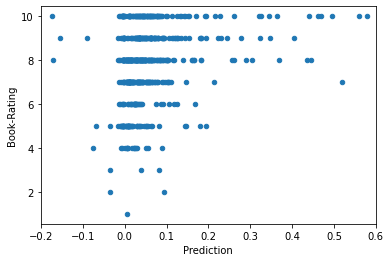

In [72]:
mypplot = df_test2.plot.scatter(x='Prediction',y='Book-Rating')
mypplot.set_xlim([-0.2, 0.6])